# What do I want?

- Match COSMOS galaxies to HSC objects 
- Remove non-matched HSC objects
- Create a classification based on COSMOS features
    - (z < 0.15) and ($10^8$ < M_stellar < $10^9$ M$_\odot$)
- Use that COSMOS classification to create an HSC training set
- Run Random Forest & Logistic Regression on that data set (pure HSC features! no COSMOS features)
- Create visual diagnostics

I'll test two basic classifiers: a RandomForest classifier and a Logistic Regression classifier. I'll try a very simplistic weak-learner: a straight i-band cut.

For my training data, I started by getting objects and labels from COSMOS. For input features, I then matched those COSMOS galaxies to their nearest HSC counterpart. I then used HSC i-band magnitude, along with HSC g-r, r-i, i-z, z-y colors.  Finally, I augment it with some HSC photo-z information (`FRANKEN-Z`).

In this notebook I'll look at the full decision curves for the classifiers, in hopes of better understanding my results.

# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

from scipy.special import expit

import pathlib

In [2]:
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = 2*np.array((8,6))
mpl.rcParams['figure.facecolor'] = "white"

In [3]:
COSMOS_filename = pathlib.Path(dwarfz.data_dir_default) / "COSMOS_reference.sqlite"
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [4]:
HSC_filename = pathlib.Path(dwarfz.data_dir_default) / "HSC_COSMOS_median_forced.sqlite3"
HSC = dwarfz.datasets.HSC(HSC_filename)

In [5]:
matches_filename = pathlib.Path(dwarfz.data_dir_default) / "matches.sqlite3"
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [6]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [7]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [8]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

## Get FRANKENZ photo-z's


In [9]:
df_frankenz = pd.read_sql_table("photo_z",
                                "sqlite:///{}".format(
                                    pathlib.Path(dwarfz.data_dir_default)
                                                 / "HSC_matched_to_FRANKENZ.sqlite"),
                                index_col="object_id")

df_frankenz.head()

,FRANKENZ_ids,photoz_best,photoz_risk_best
object_id,,,
43158034708430853,43158034708462402,3.39,0.410430
43158034708430859,43158034708462728,2.68,0.186912
43158034708430861,43158034708462729,2.57,0.565077
43158034708430866,43158034708438547,1.59,0.466111
43158034708430870,43158034708438694,2.37,0.363387


In [10]:
combined = combined.join(df_frankenz[["photoz_best", "photoz_risk_best"]],
                         on="catalog_2_ids")

# Create classification labels

In [11]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass > 8) & (combined.log_mass < 9)

In [12]:
combined["low_z_low_mass"] = (low_z & low_mass)
combined.low_z_low_mass.mean()

0.002185072976027315

In [13]:
combined.low_z_low_mass.sum()

727

In [14]:
combined.shape

(332712, 35)

# Build Classifiers

In [15]:
features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                           "icmodel_mag",
                           "photoz_best",
                           "photoz_risk_best" # The risk of photoz_best being outside of the range z_true +- 0.15(1+z_true). It ranges from 0 (safe) to 1(risky)
                          ]]

target = combined.loc[:,["low_z_low_mass"]]

In [16]:
target.mean()

low_z_low_mass    0.002185
dtype: float64

In [17]:
COSMOS_field_area = 2 # sq. degree
N_COSMOS_total = HSC.df.shape[0]
N_COSMOS_good = combined.shape[0]

true_dwarf_density = target.sum().values[0] / COSMOS_field_area 
print("true dwarf density: {:.2f} / sq. deg.".format(true_dwarf_density))

true dwarf density: 363.50 / sq. deg.


## Partition training and testing sets

In [18]:
testing_fraction = .1
np.random.seed(0)
shuffled_indices = np.random.permutation(target.index.values)

N_testing_indices = int(testing_fraction*shuffled_indices.size)
testing_set_indices  = shuffled_indices[:N_testing_indices]
training_set_indices = shuffled_indices[N_testing_indices:]

features_train = features.loc[training_set_indices]
features_test  = features.loc[testing_set_indices]

target_train   = target.loc[training_set_indices]
target_test    = target.loc[testing_set_indices]

true_dwarf     =  target_test.values.flatten()
true_non_dwarf = ~target_test.values.flatten()

In [19]:
def get_classification_characteristics(target_prob, threshold_prob, verbose=False):

    target_prediction = (target_prob > threshold_prob)
    
    prediction_dwarf     =  target_prediction
    prediction_non_dwarf = ~target_prediction
    
    completeness = (true_dwarf & prediction_dwarf).sum() / true_dwarf.sum() 
    
    purity = (true_dwarf & prediction_dwarf).sum() / prediction_dwarf.sum() 
    
    sample_size_reduction = prediction_dwarf.size / prediction_dwarf.sum()
    
    true_positives  = np.sum(true_dwarf     & prediction_dwarf)
    false_positives = np.sum(true_non_dwarf & prediction_dwarf)
    
    true_negatives  = np.sum(true_non_dwarf & prediction_non_dwarf)
    false_negatives = np.sum(true_dwarf     & prediction_non_dwarf)
    
    true_positive_rate  = true_positives  / true_dwarf.sum()
    false_positive_rate = false_positives / true_non_dwarf.sum()
    
    objects_per_sq_deg = N_COSMOS_good / COSMOS_field_area / sample_size_reduction
    
    if verbose:
        print("completeness:          ", completeness)
        print("purity:                ", purity)
        print("sample_size_reduction: ", sample_size_reduction)
        print("true  positive rate:   ", true_positive_rate)
        print("false positive rate:   ", false_positive_rate)
        print("objects per sq deg:    ", objects_per_sq_deg)
        
    return {
        "completeness": completeness,
        "purity": purity,
        "sample_size_reduction": sample_size_reduction,
        "threshold_prob": threshold_prob,
        "true_positive_rate": true_positive_rate,
        "false_positive_rate": false_positive_rate,
        "objects_per_sq_deg" : objects_per_sq_deg,
           }

## Shared Plotting Parameters

In [20]:
color_RF = "g"
color_LR = "b"
color_MC = "r"

label_RF = "Random Forest"
label_LR = "Logistic Regression"
label_MC = "Magnitude Cut"

In [21]:
threshold_probs = expit(np.linspace(-9, 6))

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

classifier_RF = RandomForestClassifier(n_estimators=1000, n_jobs=4)
classifier_RF = classifier_RF.fit(features_train, target_train.values.flatten())

target_prob_RF = classifier_RF.predict_proba(features_test)[:,1]
print("min prob: ", target_prob_RF.min())
print("max prob: ", target_prob_RF.max())


min prob:  0.0
max prob:  0.926


In [23]:
get_classification_characteristics(target_prob_RF, .01, verbose=True)

completeness:           0.8611111111111112
purity:                 0.08869814020028613
sample_size_reduction:  47.59799713876967
true  positive rate:    0.8611111111111112
false positive rate:    0.019187324919425285
objects per sq deg:     3495.021009287367


{'completeness': 0.8611111111111112,
 'purity': 0.08869814020028613,
 'sample_size_reduction': 47.59799713876967,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.8611111111111112,
 'false_positive_rate': 0.019187324919425285,
 'objects_per_sq_deg': 3495.021009287367}

In [24]:
results_RF = [get_classification_characteristics(target_prob_RF, threshold_prob)
              for threshold_prob in threshold_probs]

/Users/egentry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/egentry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


In [25]:
completenesses_RF         = [result["completeness"] for result in results_RF]
purities_RF               = [result["purity"] for result in results_RF]
sample_size_reductions_RF = [result["sample_size_reduction"] for result in results_RF]
objects_per_sq_deg_RF     = [result["objects_per_sq_deg"] for result in results_RF]
true_positive_rates_RF    = [result["true_positive_rate"] for result in results_RF]
false_positive_rates_RF   = [result["false_positive_rate"] for result in results_RF]

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(class_weight=None)
classifier_LR = classifier_LR.fit(features_train, np.array(target_train.values.flatten(), dtype=int))

target_prob_LR = classifier_LR.predict_proba(features_test)[:,1] 
print("min prob: ", target_prob_LR.min())
print("max prob: ", target_prob_LR.max())

/Users/egentry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


min prob:  2.7035566446808606e-12
max prob:  0.5475602012775044


In [27]:
get_classification_characteristics(target_prob_LR, .01, verbose=True)

completeness:           0.75
purity:                 0.05118483412322275
sample_size_reduction:  31.536492890995262
true  positive rate:    0.75
false positive rate:    0.030151510587668302
objects per sq deg:     5275.031709296384


{'completeness': 0.75,
 'purity': 0.05118483412322275,
 'sample_size_reduction': 31.536492890995262,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.75,
 'false_positive_rate': 0.030151510587668302,
 'objects_per_sq_deg': 5275.031709296384}

In [28]:
results_LR = [get_classification_characteristics(target_prob_LR, threshold_prob)
              for threshold_prob in threshold_probs]

/Users/egentry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/egentry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


In [29]:
completenesses_LR         = [result["completeness"]          for result in results_LR]
purities_LR               = [result["purity"]                for result in results_LR]
sample_size_reductions_LR = [result["sample_size_reduction"] for result in results_LR]
objects_per_sq_deg_LR     = [result["objects_per_sq_deg"]    for result in results_LR]
true_positive_rates_LR    = [result["true_positive_rate"]    for result in results_LR]
false_positive_rates_LR   = [result["false_positive_rate"]   for result in results_LR]

## i-band magnitude cut (`MC`)

**WARNING** this probability is meaningless -- it's just for convenience!

In [30]:
from scipy import stats

In [31]:
percentiles = stats.rankdata(-combined.icmodel_mag) / combined.icmodel_mag.size

target_prob_MC = pd.Series(data=percentiles, index=combined.index)
target_prob_MC = target_prob_MC.loc[testing_set_indices]

print("min prob: ", target_prob_MC.min())
print("max prob: ", target_prob_MC.max())

min prob:  9.016807328860996e-06
max prob:  0.9999609271682416


In [32]:
get_classification_characteristics(target_prob_MC, .01, verbose=True)

completeness:           1.0
purity:                 0.002186920997478966
sample_size_reduction:  1.0105701181544817
true  positive rate:    1.0
false positive rate:    0.9895177565589325
objects per sq deg:     164615.9895404406


{'completeness': 1.0,
 'purity': 0.002186920997478966,
 'sample_size_reduction': 1.0105701181544817,
 'threshold_prob': 0.01,
 'true_positive_rate': 1.0,
 'false_positive_rate': 0.9895177565589325,
 'objects_per_sq_deg': 164615.9895404406}

In [33]:
results_MC = [get_classification_characteristics(target_prob_MC, threshold_prob)
              for threshold_prob in threshold_probs]

In [34]:
completenesses_MC         = [result["completeness"]          for result in results_MC]
purities_MC               = [result["purity"]                for result in results_MC]
sample_size_reductions_MC = [result["sample_size_reduction"] for result in results_MC]
objects_per_sq_deg_MC     = [result["objects_per_sq_deg"]    for result in results_MC]
true_positive_rates_MC    = [result["true_positive_rate"]    for result in results_MC]
false_positive_rates_MC   = [result["false_positive_rate"]   for result in results_MC]

## Combined plots

Text(0.5, 1.0, 'ROC Curve')

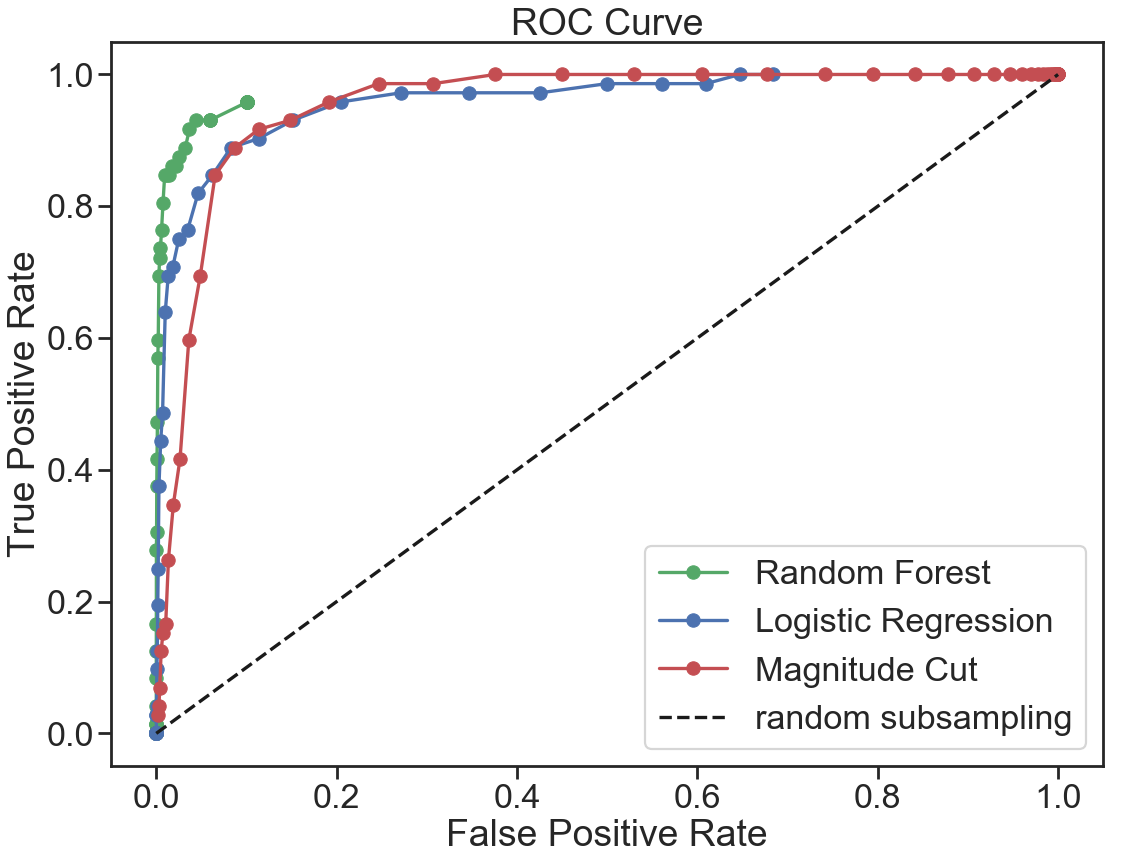

In [35]:
plt.plot(false_positive_rates_RF, true_positive_rates_RF, 
         marker="o", label=label_RF, color=color_RF)

plt.plot(false_positive_rates_LR, true_positive_rates_LR, 
         marker="o", label=label_LR, color=color_LR)

plt.plot(false_positive_rates_MC, true_positive_rates_MC, 
         marker="o", label=label_MC, color=color_MC)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")

plt.title("ROC Curve")

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score

precision, recall, _  = precision_recall_curve(target_test,
                                          target_prob_RF)

pr_auc = average_precision_score(target_test, target_prob_RF)


FPR, TPR, _  = roc_curve(target_test,
                                          target_prob_RF)

roc_auc = roc_auc_score(target_test, target_prob_RF)

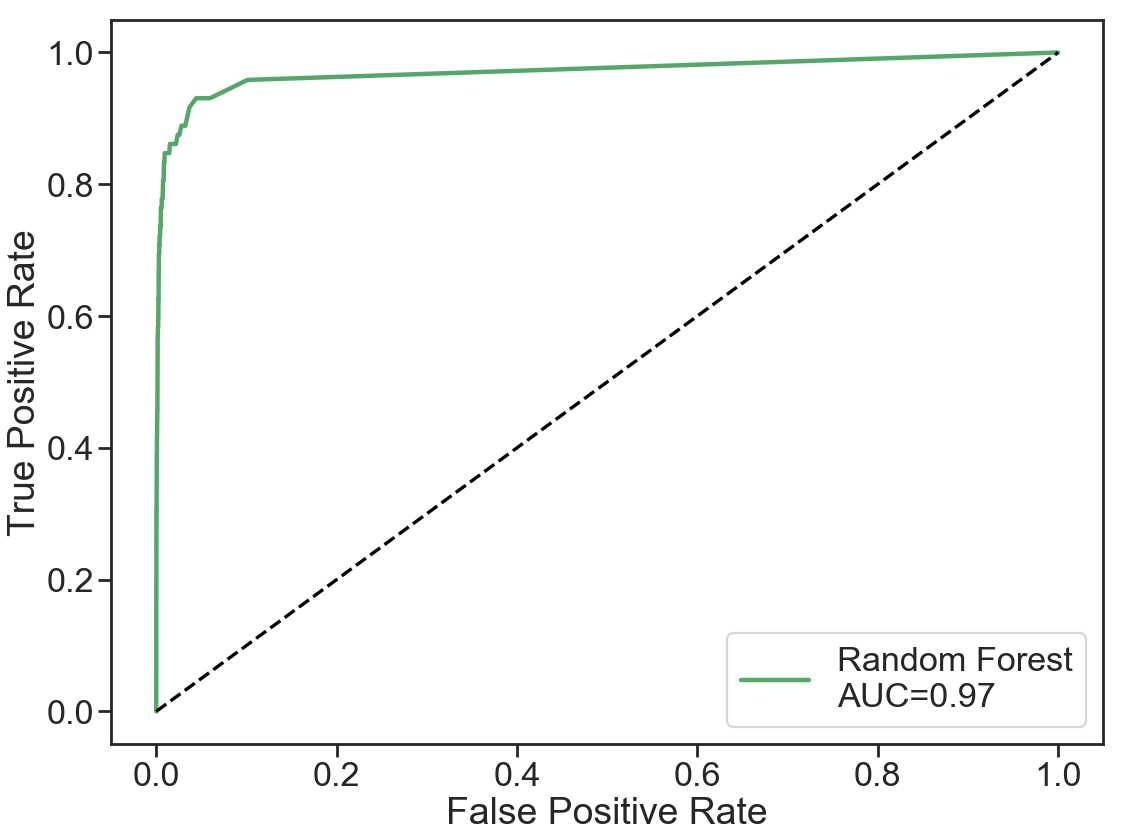

In [37]:
plt.plot(FPR, TPR, color=color_RF, label=label_RF + "\nAUC={:.2f}".format(roc_auc),
        linewidth=4
        )

plt.plot([0,1], [0,1], linestyle="dashed", color="black")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# plt.xlim(-0.05,1)
# plt.ylim(0,1)

plt.legend(loc="best")

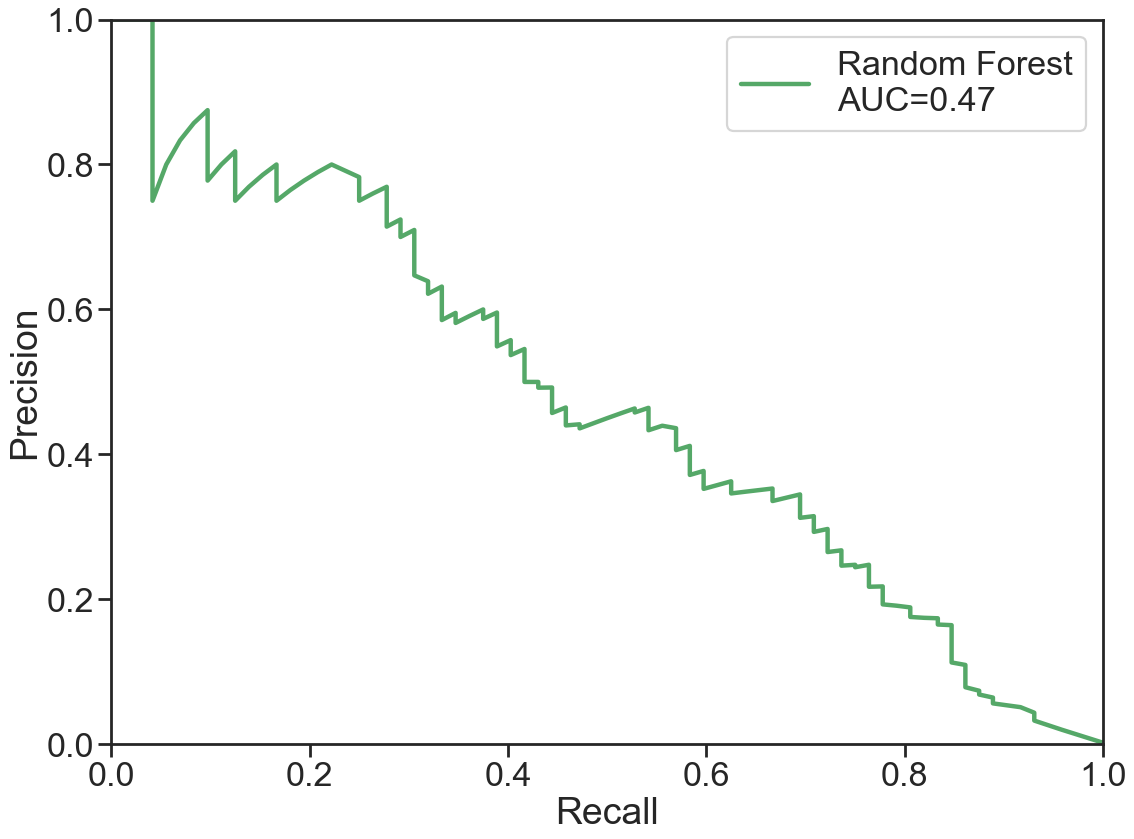

In [38]:
plt.plot(recall, precision, color=color_RF, label=label_RF + "\nAUC={:.2f}".format(pr_auc),
        linewidth=4
        )


plt.xlabel("Recall")
plt.ylabel("Precision")

plt.xlim(0,1)
plt.ylim(0,1)

plt.legend(loc="best")

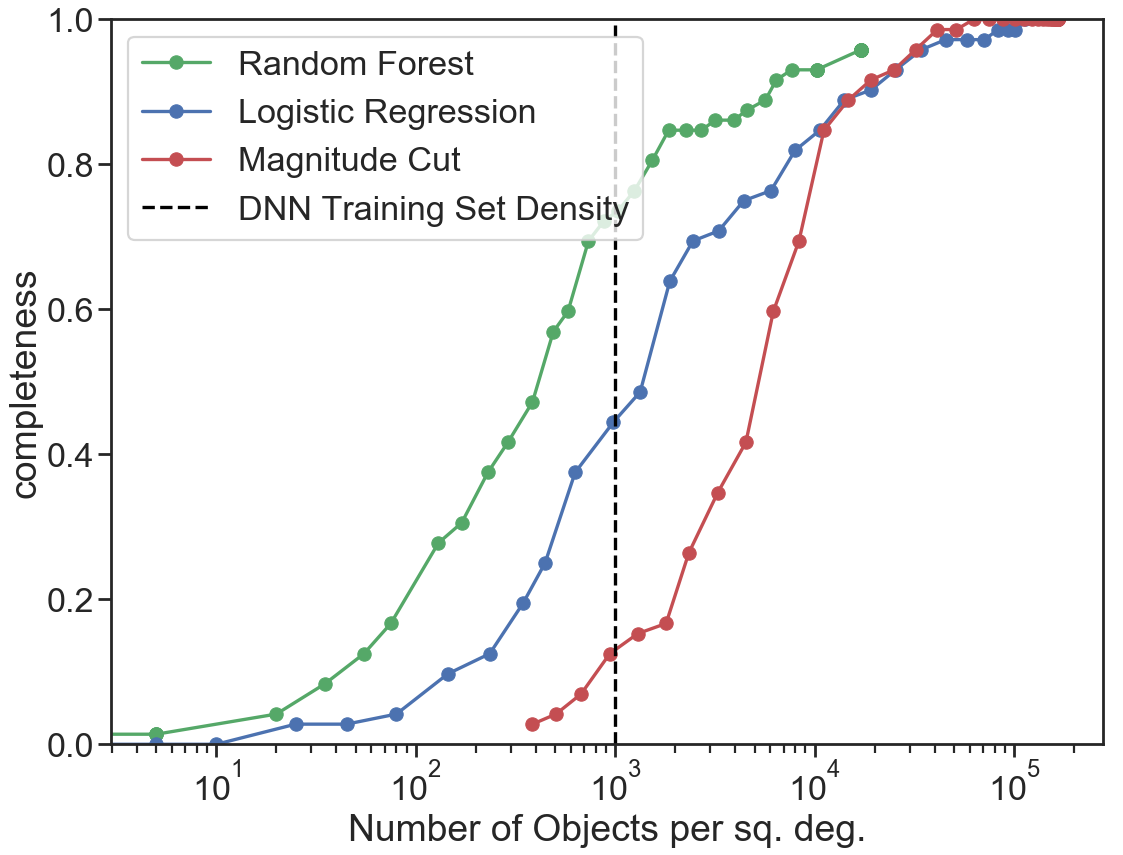

In [39]:
plt.plot(objects_per_sq_deg_RF, completenesses_RF, 
         marker="o", color=color_RF, label=label_RF,
        )

plt.plot(objects_per_sq_deg_LR, completenesses_LR, 
         marker="o", color=color_LR, label=label_LR,
        )

plt.plot(objects_per_sq_deg_MC, completenesses_MC, 
         marker="o", color=color_MC, label=label_MC,
        )

plt.axvline(1e3,
           color="black", linestyle="dashed", label="DNN Training Set Density")

plt.xlabel("Number of Objects per sq. deg.")
plt.ylabel("completeness")
plt.xscale("log")

plt.ylim(0,1)

plt.legend(loc="best")

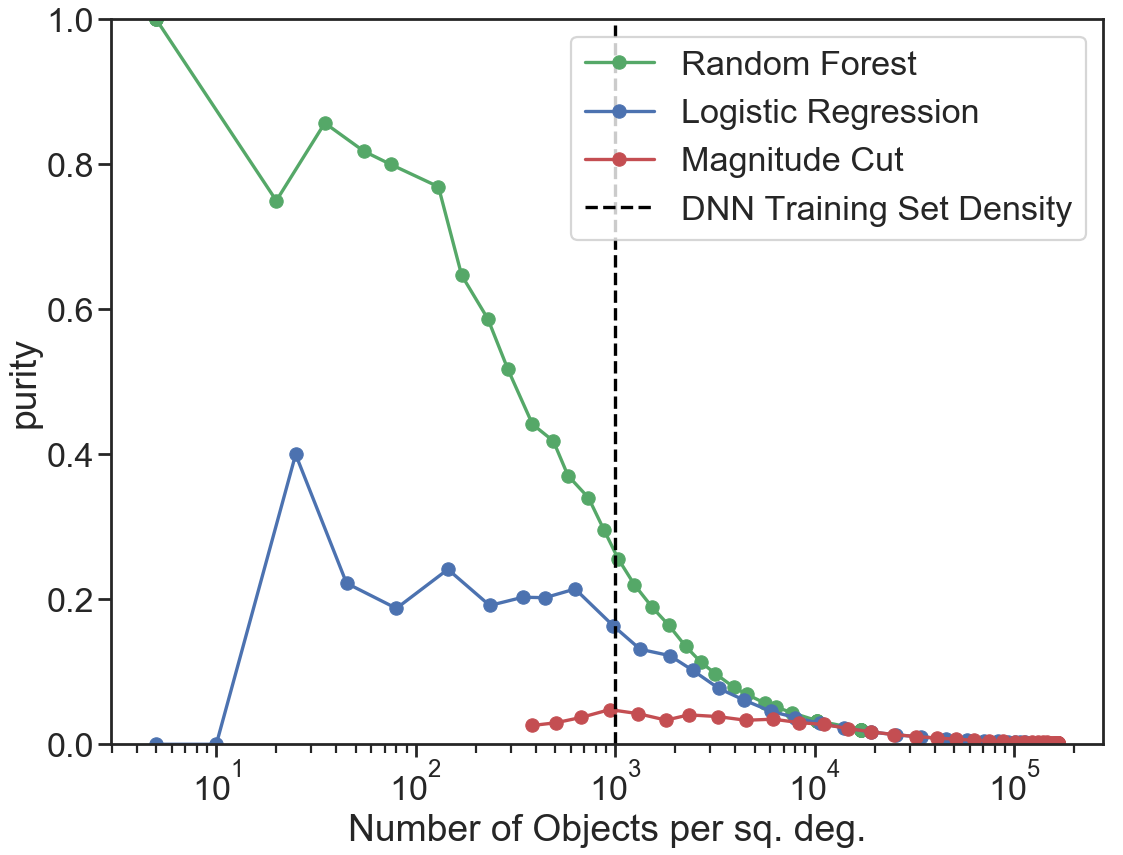

In [40]:
plt.plot(objects_per_sq_deg_RF, purities_RF, 
         marker="o", color=color_RF, label=label_RF)

plt.plot(objects_per_sq_deg_LR, purities_LR, 
         marker="o", color=color_LR, label=label_LR)

plt.plot(objects_per_sq_deg_MC, purities_MC, 
         marker="o", color=color_MC, label=label_MC)

plt.axvline(1e3,
           color="black", linestyle="dashed", label="DNN Training Set Density")

plt.xlabel("Number of Objects per sq. deg.")
plt.ylabel("purity")
plt.xscale("log")
plt.ylim(0,1)

plt.legend(loc="best")

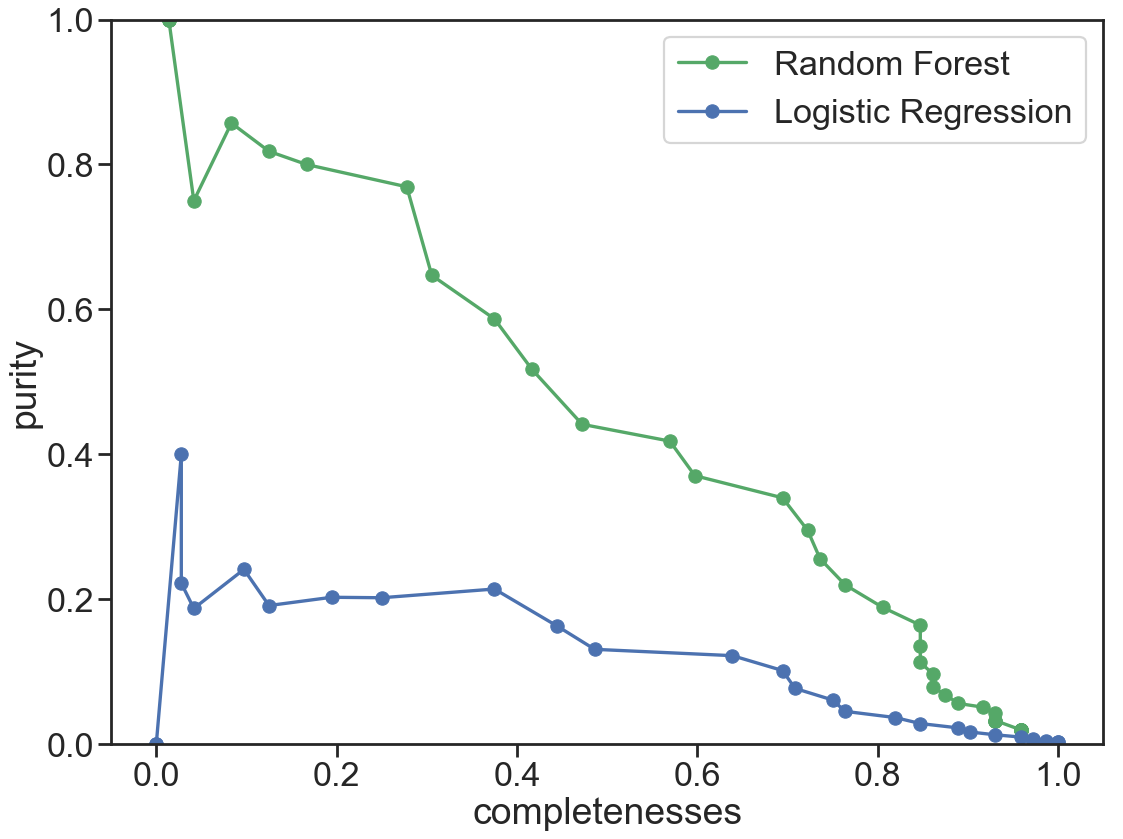

In [41]:
plt.plot(completenesses_RF, purities_RF, 
         marker="o", color=color_RF, label="Random Forest", 
        )
plt.plot(completenesses_LR, purities_LR, 
         marker="o", color=color_LR, label="Logistic Regression", 
        )

plt.xlabel("completenesses")
plt.ylabel("purity")
plt.ylim(0,1)


plt.legend(loc="best")

# Check Probability Calibration

## Predicted Probabilities

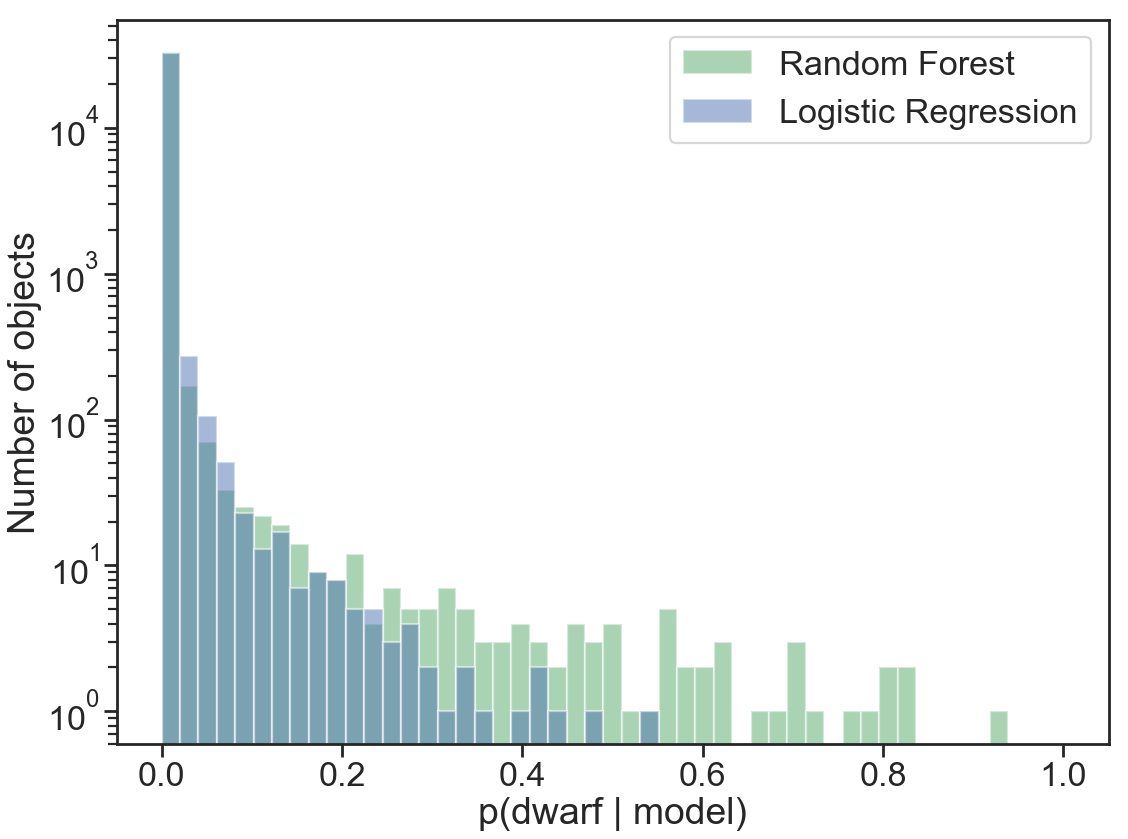

In [42]:
plt.hist(target_prob_RF, bins=np.linspace(0,1), alpha=.5, color=color_RF, label=label_RF)
plt.hist(target_prob_LR, bins=np.linspace(0,1), alpha=.5, color=color_LR, label=label_LR)

plt.yscale("log")
plt.xlabel("p(dwarf | model)")
plt.ylabel("Number of objects")

plt.legend(loc="best")

/Users/egentry/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


Text(0, 0.5, 'CDF')

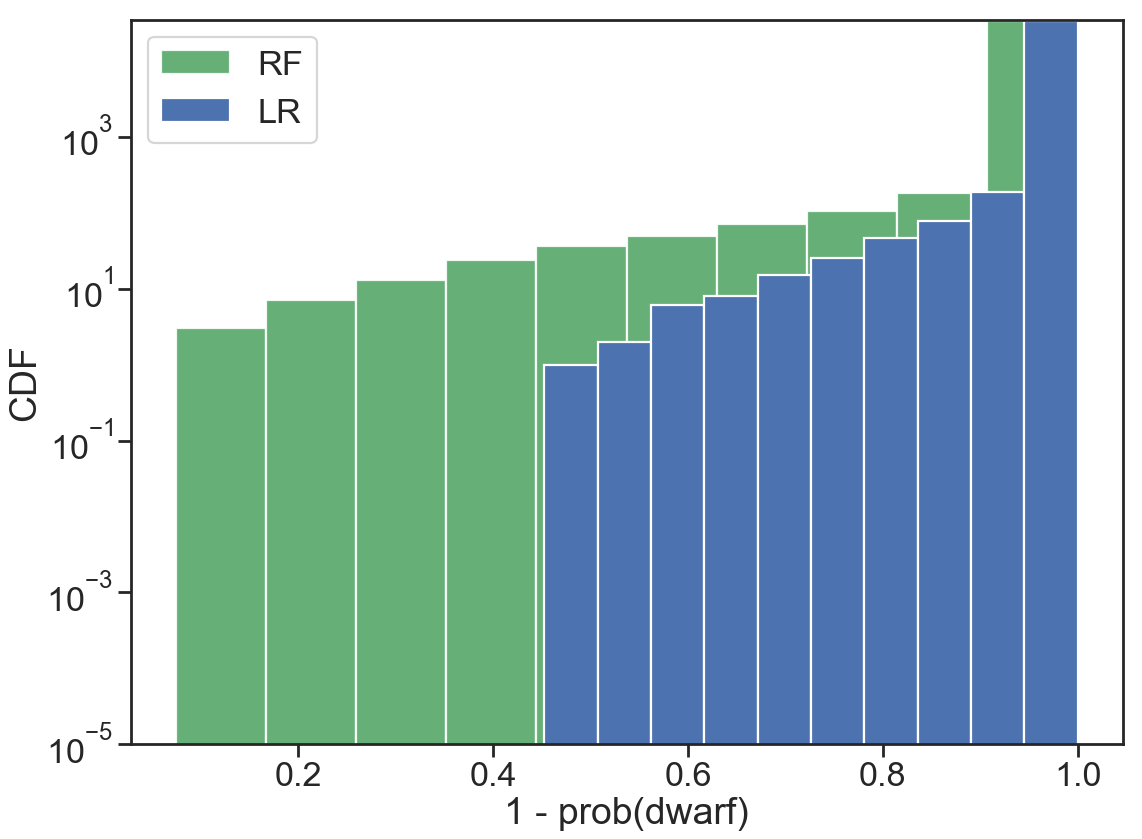

In [43]:
plt.hist(1-target_prob_RF,
         cumulative=True, alpha=0.9,
         label="RF",
         color=color_RF)

plt.hist(1-target_prob_LR,
         cumulative=True,
         label="LR",
         color=color_LR)

plt.ylim(ymin=1e-5)
plt.yscale("log")

plt.legend(loc="best")
plt.xlabel("1 - prob(dwarf)")
plt.ylabel("CDF")

## Empirical (Binned) Probabilities

In [44]:
theoretical_probs=np.linspace(0,1,num=11)

In [45]:
empirical_probs_RF = np.empty(theoretical_probs.size-1)
empirical_probs_LR = np.empty_like(empirical_probs_RF)

In [46]:
for i in range(theoretical_probs.size-1):
    prob_lim_low  = theoretical_probs[i]
    prob_lim_high = theoretical_probs[i+1]
    
    mask_RF = (target_prob_RF >= prob_lim_low) & (target_prob_RF < prob_lim_high)
    empirical_probs_RF[i] = target_test[mask_RF].mean()
    
    mask_LR = (target_prob_LR >= prob_lim_low) & (target_prob_LR < prob_lim_high)
    empirical_probs_LR[i] = target_test[mask_LR].mean()

(0, 1)

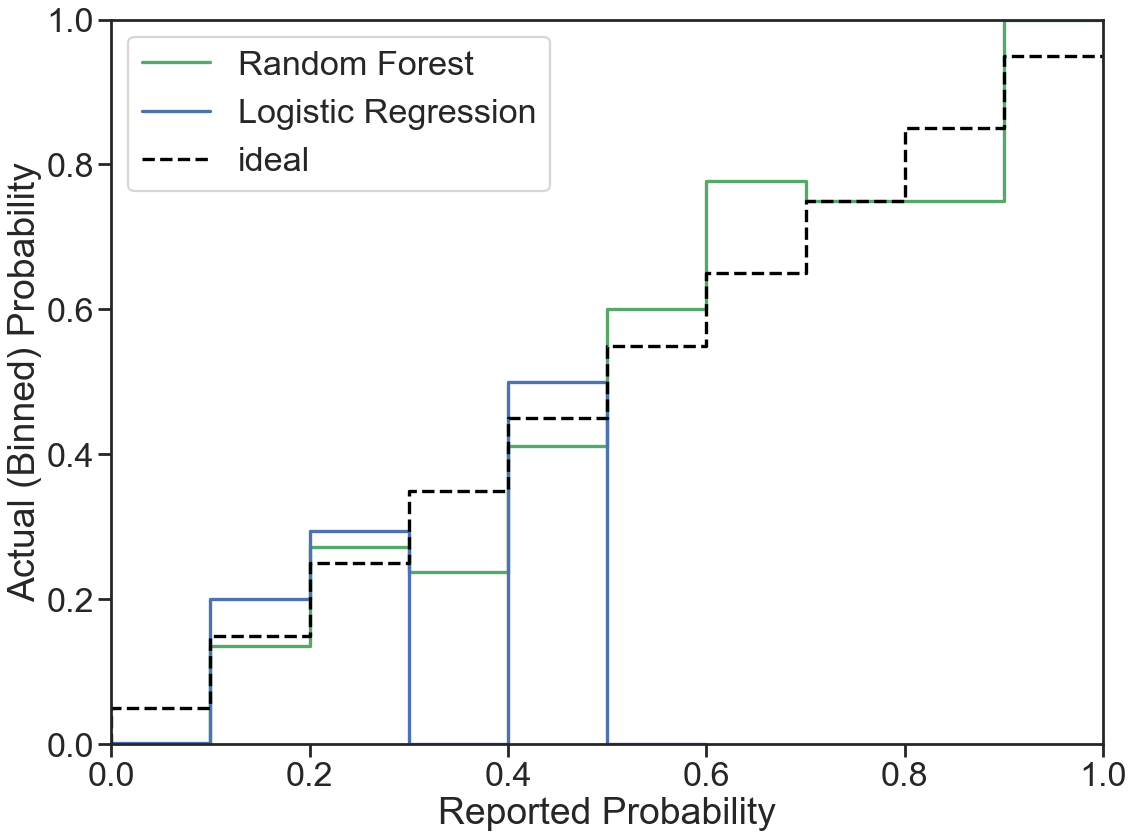

In [47]:
plt.step(theoretical_probs, [empirical_probs_RF[0], *empirical_probs_RF], 
         linestyle="steps", color=color_RF, label=label_RF)
plt.step(theoretical_probs, [empirical_probs_LR[0], *empirical_probs_LR], 
         linestyle="steps", color=color_LR, label=label_LR)

plt.plot(theoretical_probs, theoretical_probs-.05, 
         drawstyle="steps", color="black", label="ideal", linestyle="dashed")

plt.xlabel("Reported Probability")
plt.ylabel("Actual (Binned) Probability")

plt.legend(loc="best")

plt.xlim(0,1)
plt.ylim(0,1)


# Get RF scores for each galaxy
We'll do this in chunks. The general approach is:

1)  Split the galaxies into 10 random buckets

2) Using 9 buckets, train a model

3) Apply that model to the held-out bucket. Each galaxy in the held-out bucket gets a "score" which is the probability that the galaxy is a dwarf as predicted by the model

4) Repeat steps 2+3, so each bucket is held out once

5) Combine these scores together. Each galaxy should have 1 and only 1 score, and that score shouldn't have any label leakage. But remember, these scores come from 10 different models now, not a single model.

In [48]:
N_folds = 10
np.random.seed(0)
shuffled_indices = np.random.permutation(target.index.values)

partition_edges = np.linspace(0, shuffled_indices.size, num=N_folds+1, dtype=int)

df_dwarf_prob = pd.DataFrame(data={"dwarf_prob":-1}, index=shuffled_indices)
df_dwarf_prob = df_dwarf_prob.join(target)

for i in range(N_folds):
    print("Starting fold: {}".format(i))

    testing_set_start_edge = partition_edges[i]
    testing_set_end_edge   = partition_edges[i+1]
    
    testing_indices = shuffled_indices[testing_set_start_edge:testing_set_end_edge]
    training_indices = np.concatenate([
        shuffled_indices[0:testing_set_start_edge],
        shuffled_indices[testing_set_end_edge:],
    ])
    
    assert(np.all(~np.isin(testing_indices,  training_indices)))
    assert(np.all(~np.isin(training_indices, testing_indices)))
    
    classifier_RF = RandomForestClassifier(n_estimators=1000, n_jobs=4)
    classifier_RF = classifier_RF.fit(features.loc[training_indices],
                                      target.loc[training_indices].values.flatten())

    target_prob = classifier_RF.predict_proba(features.loc[testing_indices])[:,1]
    target_prob = target_prob.reshape((target_prob.size, 1))
        
    df_dwarf_prob.loc[testing_indices,["dwarf_prob"]] = target_prob
    
df_dwarf_prob["HSC_id"] = combined.catalog_2_ids
df_dwarf_prob = df_dwarf_prob[["HSC_id", "dwarf_prob", "low_z_low_mass"]]

print(partition_edges)
print(shuffled_indices.size)

Starting fold: 0
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Starting fold: 6
Starting fold: 7
Starting fold: 8
Starting fold: 9
[     0  33271  66542  99813 133084 166356 199627 232898 266169 299440
 332712]
332712


In [49]:
target_prob.min()

0.0

In [50]:
df_dwarf_prob.dwarf_prob.min()

0.0

In [51]:
print(target.shape)
print(df_dwarf_prob.shape)
df_dwarf_prob.head()

(332712, 1)
(332712, 3)


,HSC_id,dwarf_prob,low_z_low_mass
836325,43158193622222921,0.00,False
718099,43158876522024067,0.00,False
723315,43158464205163582,0.02,False
553864,43159009666014983,0.00,False
285569,43158859342157087,0.00,False


In [52]:
theoretical_probs=np.linspace(0,1,num=20+1)

In [53]:
empirical_probs_RF = np.empty(theoretical_probs.size-1)

In [54]:
for i in range(theoretical_probs.size-1):
    prob_lim_low  = theoretical_probs[i]
    prob_lim_high = theoretical_probs[i+1]
    
    mask_RF = (df_dwarf_prob.dwarf_prob >= prob_lim_low) & (df_dwarf_prob.dwarf_prob < prob_lim_high)
    empirical_probs_RF[i] = df_dwarf_prob.low_z_low_mass[mask_RF].mean()

(0, 1)

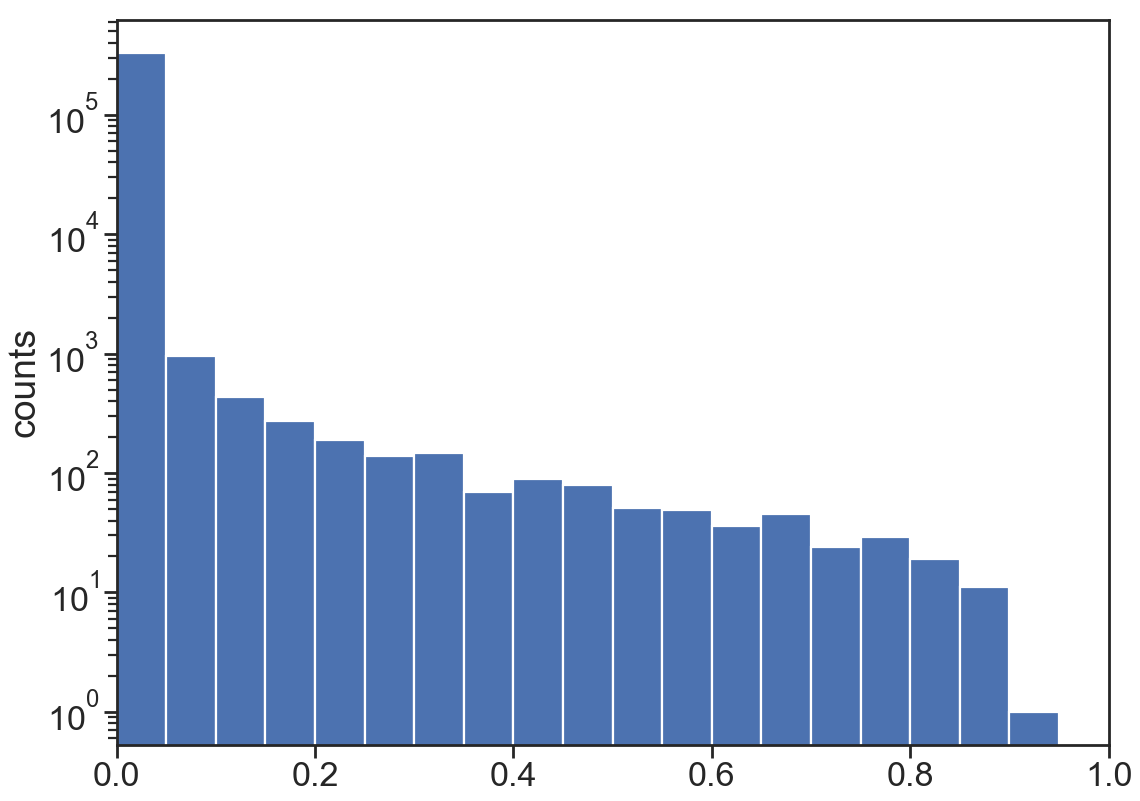

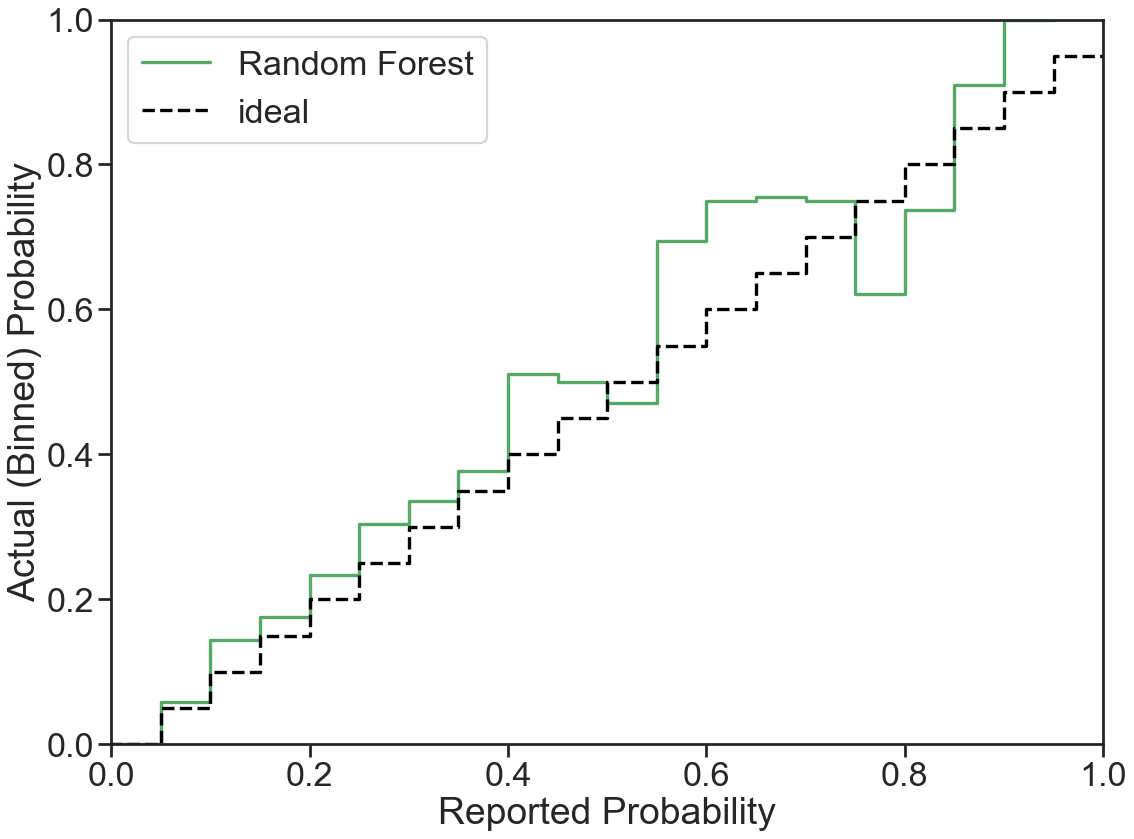

In [55]:
plt.hist(df_dwarf_prob.dwarf_prob, bins=theoretical_probs)
plt.xlim(0,1)
plt.yscale("log")
plt.ylabel("counts")

plt.figure()


plt.step(theoretical_probs, [empirical_probs_RF[0], *empirical_probs_RF], 
         linestyle="steps", color=color_RF, label=label_RF)

plt.plot(theoretical_probs, theoretical_probs-.05, 
         drawstyle="steps", color="black", label="ideal", linestyle="dashed")

plt.xlabel("Reported Probability")
plt.ylabel("Actual (Binned) Probability")

plt.legend(loc="best")

plt.xlim(0,1)
plt.ylim(0,1)


### save scores for all galaxies


In [56]:
!ls ../data/galaxy_images_training/

2017_09_26-coords.csv                 quarry_files
2017_09_26-dwarf_galaxy_scores.csv    quarry_input_files
2017_09_26-selected_galaxy_coords.csv quarry_output
2018_02_23-all_objects.csv            test_output
2019_01_10-selected_galaxy_coords.csv tmp_quarry_example.txt
curl_netrc


In [57]:
df_dwarf_prob.head()

,HSC_id,dwarf_prob,low_z_low_mass
836325,43158193622222921,0.00,False
718099,43158876522024067,0.00,False
723315,43158464205163582,0.02,False
553864,43159009666014983,0.00,False
285569,43158859342157087,0.00,False


In [58]:
filename = pathlib.Path("../data/galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv")
if not filename.exists():
    df_dwarf_prob.to_csv(filename, index_label="COSMOS_id")


In [59]:
!head -n 20 $filename

COSMOS_id,HSC_id,dwarf_prob,low_z_low_mass
628457,43158322471244656,0.0,False
919771,43158605939114836,0.0,False
444239,43159142810013665,0.0,False
569427,43158734788125011,0.06333333333333334,False
369948,43158863637144621,0.6066666666666667,True
774881,43158464205193248,0.0,False
284143,43158309586361270,0.0,False
910106,43158468500160065,0.0,False
988664,43158747673006735,0.0,False
718450,43159151399949013,0.0,False
856273,43158193622240311,0.0,False
627429,43158322471244576,0.0,False
807370,43158468500150416,0.0,False
746672,43158464205165131,0.0,False
901924,43159018255969735,0.0,False
902781,43158468500159652,0.0,False
845231,43158743378044104,0.0,False
323432,43158588759212951,0.0,False
256187,43158584464272098,0.0,False


## check out the best 1000 / sq.deg.

In [60]:
sample_size = int(1000 * COSMOS_field_area)
print("sample size: ", sample_size)

sample size:  2000


In [61]:
selected_galaxies = df_dwarf_prob.sort_values("dwarf_prob", ascending=False)[:sample_size]
print("threshold: ", selected_galaxies.dwarf_prob.min())
print("galaxies at or above threshold: ", 
      (df_dwarf_prob.dwarf_prob>=selected_galaxies.dwarf_prob.min()).sum() )

threshold:  0.076
galaxies at or above threshold:  2017


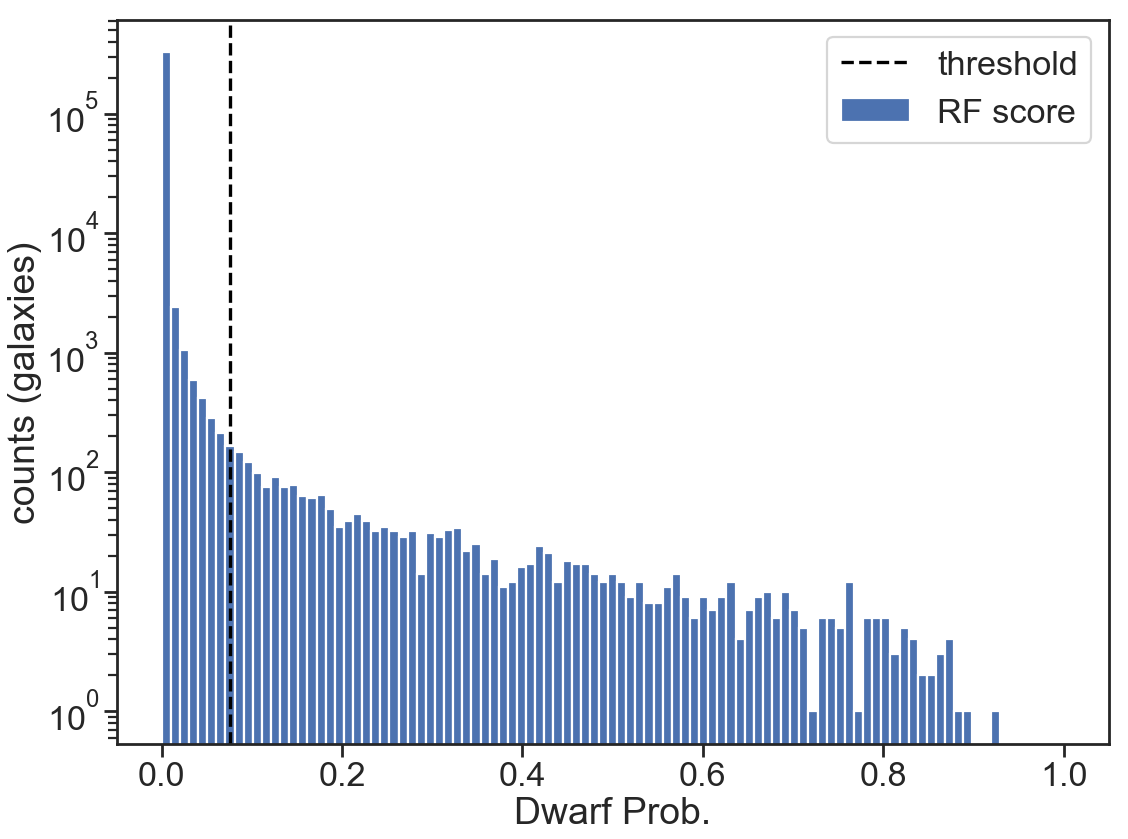

In [62]:
bins = np.linspace(0,1, num=100)

plt.hist(df_dwarf_prob.dwarf_prob, bins=bins, label="RF score")

plt.axvline(selected_galaxies.dwarf_prob.min(), 
            linestyle="dashed", color="black", label="threshold")

plt.legend(loc="best")

plt.xlabel("Dwarf Prob.")
plt.ylabel("counts (galaxies)")
plt.yscale("log")

In [63]:
# how balanced is the CNN training set? What fraction are actually dwarfs?
selected_galaxies.low_z_low_mass.mean()

0.2805

# How do I actually get the images for the selected galaxies?
Check out `../data/get_training_galaxy_images.ipynb`